# dominating set

Set up calculations and store in EspressoDB

In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import os

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import (
    graph_summary,
    experiment_summary,
    data_summary,
    insert_result,
    QUBO_to_Ising,
    retry_embedding,
    find_offset,
    AnnealOffset,
    plot_anneal_offset,
)

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw
from networkx.algorithms.approximation import min_weighted_dominating_set
from networkx.algorithms.dominating import dominating_set

from dwave.system.samplers import DWaveSampler
from minorminer import find_embedding
from dwave.system.composites import EmbeddingComposite, FixedEmbeddingComposite

In [2]:
# plot anneal offset ranges
#solver = "DW_2000Q_5"
#sampler = DWaveSampler(solver=solver)
#plot_anneal_offset(sampler)

spin reversal: 0


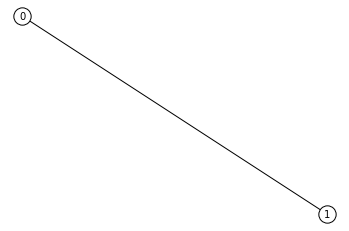

{'tag': 'NN(2)', 'total_vertices': 2, 'total_edges': 1, 'total_qubits': 4, 'max_edges': 1, 'adjacency': [[0, 1]], 'adjacency_hash': '2864ee150babb3f03de5e76a1733df4b'}
Greedy solution
 {0}
0.5
0.375
Solving 1/5{(0, 0): -0.75, (0, 1): 2.0, (1, 1): -0.75, (0, 2): -1.0, (1, 2): -1.0, (2, 2): 1.5, (0, 3): -1.0, (1, 3): -1.0, (3, 3): 1.5}
{'anneal_offsets': ['parameters'], 'anneal_schedule': ['parameters'], 'annealing_time': ['parameters'], 'answer_mode': ['parameters'], 'auto_scale': ['parameters'], 'beta': ['parameters'], 'chains': ['parameters'], 'flux_biases': ['parameters'], 'flux_drift_compensation': ['parameters'], 'h_gain_schedule': ['parameters'], 'initial_state': ['parameters'], 'max_answers': ['parameters'], 'num_reads': ['parameters'], 'num_spin_reversal_transforms': ['parameters'], 'postprocess': ['parameters'], 'programming_thermalization': ['parameters'], 'readout_thermalization': ['parameters'], 'reduce_intersample_correlation': ['parameters'], 'reinitialize_state': ['parame

SystemExit: 

/Users/metafalass/anaconda3/envs/quantum_linear_programming/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
# Define Adjacency matrix
# graph, tag = gt.generate_nn_graph(v)
# graph, tag = gt.generate_hamming_graph(d, v)
# graph, tag = gt.generate_bipartite_graph(p, q)
# graph, tag = gt.generate_newman_watts_strogatz_graph(v, n, p)
# graph, tag = gt.generate_corona_graph(k, n)

# Define anneal offset
# "constant": no offset
# "linear": linear with respect to |h|

#for offsetx in [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]:
for _ in range(5): # global for loop cycle to average over any time dependence due to how the for loop is set up
    for pmin in [-0.05, -0.04, -0.03, -0.02, -0.01, 0.0]:
        for offtype in ["binary"]:
            for nvertices in range(2, 3):
                for at in [1]:
                    for srt in [0]:
                        print("spin reversal:", srt)
                        """User defined inputs"""
                        # Define graph
                        #graph, tag = gt.generate_limited_corona_graph(2, nvertices)
                        graph, tag = gt.generate_nn_graph(nvertices)
                        penalty = 2
                        # Embedding retries
                        retries = 100000
                        # Set functional form of anneal offset
                        target_min = -0.05
                        target_range = 0.10
                        problem_min = pmin
                        problem_range = 2*abs(pmin)
                        #problem_range = abs(pmin)
                        # DWave parameters
                        annealing_time = at  # integer microseconds [1, 2000] #OPTIMIZED
                        answer_mode = "raw"  # histogram or raw
                        auto_scale = False
                        num_reads = 1000  # raw will dump out all results
                        num_spin_reversal_transforms = srt # OPTIMIZED
                        readout_thermalization = 0  # default 0
                        programming_thermalization = 1000  # default 1000
                        # Iterate for more statistics
                        iterations = 5
                        insertdb = True
    
                        """Start program"""
                        # get qubo
                        directed = False
                        qubo = get_mds_qubo(
                            graph, directed=directed, penalty=penalty, triangularize=True, dtype="d"
                        )
                        qubo = qubo/4
                        q_min = np.array(list(qubo.values())).min()
                        graph_params = graph_summary(tag, graph, qubo)
                        offsetcls = AnnealOffset(offtype, graph_params=graph_params)
                        # plot graph
                        gt.get_plot(graph, directed=directed)
                        plt.show()
                        graph_params = graph_summary(tag, graph, qubo)
                        print(graph_params)
    
                        # greedy solution
                        G = nx.Graph()
                        G.add_edges_from(graph)
                        print("Greedy solution\n", dominating_set(G))
    
                        # convert to Ising
                        J, h, C = QUBO_to_Ising(qubo.todense().tolist())
                        maxJ = max(abs(J).flatten())
                        maxh = max(abs(h))
                        print(maxJ)
                        print(maxh)
                        # Set chain strength
                        chain_strength = maxJ * 2
    
                        # DWave settings
                        solver = "DW_2000Q_6"
                        sampler = DWaveSampler(solver=solver)
    
                        qpu_graph = sampler.edgelist
                        qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}
                        for idx in range(iterations):
                            print(f"\rSolving {idx+1}/{iterations}", end="")
                            embed, embedding, min_offset, max_offset = retry_embedding(
                                sampler=sampler,
                                qubo_dict=qubo_dict,
                                qpu_graph=qpu_graph,
                                graph_tag=tag,
                                target_min=target_min,
                                target_range=target_range,
                                n_tries=retries,
                            )
                            a = ['children', 'embedding_parameters', 'find_embedding', 'parameters', 'properties', 'target_structure', 'scale_aware', 'embedding']
                            anneal_offsets, exp_tag = find_offset(
                                h=h,
                                fcn=offsetcls.fcn,
                                embedding=embedding,
                                offset_min=problem_min,
                                offset_range=problem_range,
                            )
                            dwave_config = {
                                "annealing_time": annealing_time,  # integer microseconds [1, 2000]
                                "answer_mode": answer_mode,  # histogram or raw
                                "auto_scale": auto_scale,
                                "num_reads": num_reads,  # raw will dump out all results
                                "num_spin_reversal_transforms": num_spin_reversal_transforms,
                                "readout_thermalization": readout_thermalization,  # default 0
                                "programming_thermalization": programming_thermalization,  # default 1000
                                "chain_strength": chain_strength,
                                "anneal_offsets": anneal_offsets,
                            }
    
                            experiment_params = experiment_summary(
                                machine=solver,
                                settings=dwave_config,
                                penalty=penalty,
                                chain_strength=chain_strength,
                                tag=exp_tag,
                            )
                            # Solve on DWave and push to database
                            result = embed.sample_qubo(qubo_dict, **dwave_config)
                            print(qubo_dict)
                            print(vars(embed)['parameters'])
                            print(embedding)
                            print(h)
                            print(J)
                            print(chain_strength)
                            raise SystemExit
                            raw = result.to_pandas_dataframe()
                            data_params = data_summary(raw, graph_params, experiment_params)
                            if insertdb:
                                result = insert_result(graph_params, experiment_params, data_params)
                            #print(raw.sort_values("energy", ascending=True))
print("\nDONE")

In [ ]:
raw.sort_values("energy", ascending=True)